In [6]:
import matplotlib.pyplot as plt
import scipy.optimize
import jax
from jax.nn import softmax
from jax import grad, jit
import jax.numpy as jnp
from jax.experimental import optimizers
import time
%run Dendrogram.ipynb

In [47]:
def energy(params, locs, masses, weights):        

    E = 0
    c0 = 100
    c1 = 0
    c2 = 10
    
    prev_p_j = 0
    for t in range(len(params)):
        link_mat = softmax(params[t][[0], :, :], axis=1)
        mass_mat = link_mat * masses[t][:, None]
        v_mat = params[t][1:, :, :]
        p_mat = mass_mat * v_mat
        p_j = jnp.sum(p_mat, axis=1)
        m_j = jnp.sum(mass_mat, axis=1)
        x_nxt = locs[t+1].T
        
        x_cur = locs[t].T
        com_j = jnp.sum(mass_mat*x_cur[:, :, None], axis=1) / m_j
        overshoot = 1*p_j/m_j - (x_nxt - com_j)
        penalty = weights[t+1] * jnp.linalg.norm(overshoot, axis=0)
        dE_inertia = c0 * jnp.sum(penalty)
        
        p_i = jnp.sum(p_mat, axis=2)
        momentum_lost = p_i - prev_p_j
        penalty = weights[t] * jnp.linalg.norm(momentum_lost, axis=0)
        dE_momentum = c1 * jnp.sum(penalty)
        c1 = 1
        prev_p_j = p_j
        
        dE_v_div = 0
        for i in range(v_mat.shape[1]):
            v_div = jnp.trace(jnp.cov(v_mat[:, i, :]))
            dE_v_div += c2 * v_div
            
        E += dE_inertia + dE_momentum + dE_v_div
    
    return E

def process_dendrograms(dendrograms, thresh):
    link_matrices = []
    for t in range(len(dendrograms)-1):
        cur_sz = dendrograms[t].size
        next_sz = dendrograms[t+1].size
        link_mat = np.zeros((3, cur_sz, next_sz))
        for i, j in np.ndindex(cur_sz, next_sz):
            loc = dendrograms[t].branches[i].loc
            vel = 10 * loc / np.linalg.norm(loc)
            link_mat[1:, i, j] = vel
            sep = dendrograms[t+1].branches[j].loc - dendrograms[t].branches[i].loc
            if np.linalg.norm(sep) < thresh:
                link_mat[0, i, j] = 1
        link_matrices.append(link_mat)
    return link_matrices

In [56]:
fn = 12
dendros = []
for frame_num in range(fn, fn+5):
#     orig = cv2.imread("test_images/tracer/{}.png".format(frame_num),
#                       cv2.IMREAD_GRAYSCALE)
#     orig = orig[50:825, 125:900]
#     orig = cv2.resize(orig, (300, 300))
    orig = cv2.imread("gen/{:02d}.png".format(frame_num), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    im = cv2.GaussianBlur(orig, (3, 3), cv2.BORDER_CONSTANT)
    d = make_dendrogram(-im, frame_num)
    dendros.append(d)

In [57]:
energy = jit(energy, static_argnums=(1,2,3))
grad_energy = jit(grad(energy, argnums=0), static_argnums=(1,2,3))
links = process_dendrograms(dendros, 100)
locs = []
masses = []
wts = []
for d in dendros:
    locs.append(np.asarray([b.loc for b in d.branches]))
    masses.append(np.asarray([b.exclusive_mass for b in d.branches]))
    wts.append(np.asarray([b.weight for b in d.branches]))
print(energy(links, locs, masses, wts))

opt_init, opt_update, get_params = optimizers.adam(step_size=.01)

@jit
def update(i, opt_state):
    links = get_params(opt_state)
    return opt_update(i, grad_energy(links, locs, masses, wts), opt_state)

opt_state = opt_init(links)
    
for step in range(15000):
    opt_state = update(step, opt_state)
    step += 1

links = get_params(opt_state)
print(energy(links, locs, masses, wts))
print()

3281660.5
8492.31



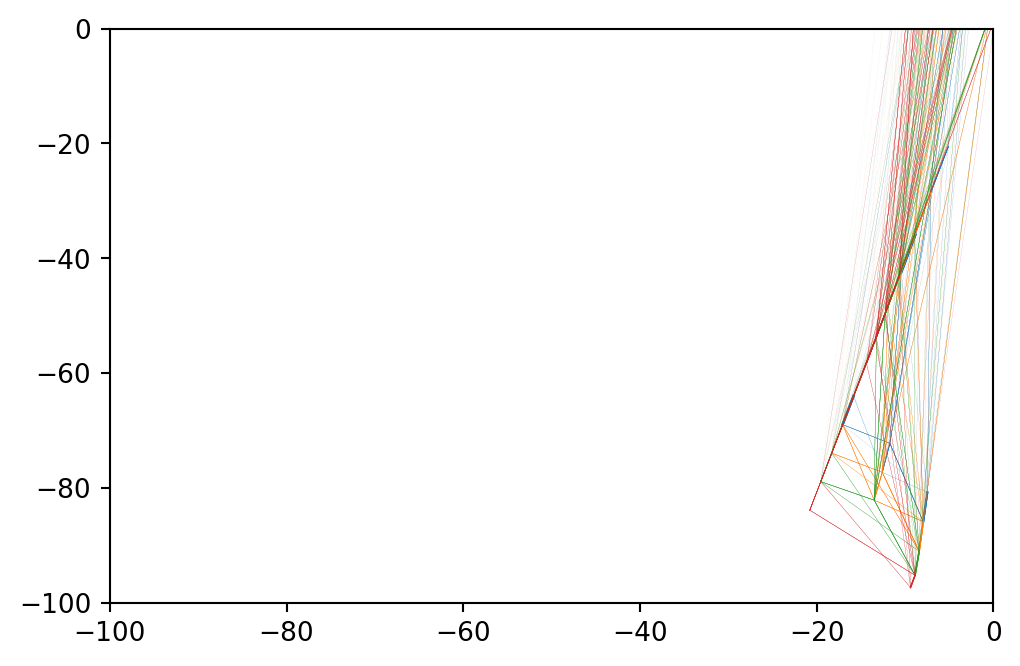

In [59]:
def draw_traj(opt, dendros, xbound=(-100,100), ybound=(-100,100)):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for t in range(len(dendros)-1):
        cur_d = dendros[t].branches
        next_d = dendros[t+1].branches
        links = softmax(opt[t], axis=2)
        color = colors[t%len(colors)]
        for _, i, j in np.ndindex(*links.shape):
            x = [cur_d[i].loc[0], next_d[j].loc[0]]
            y = [cur_d[i].loc[1], next_d[j].loc[1]]
            if cur_d[i].weight > 0.3 and next_d[j].weight > 0.3:
                plt.plot(x, y, linewidth=links[0,i,j], color=color)
    plt.xlim(xbound)
    plt.ylim(ybound)
    plt.show()

plt.close()
draw_traj(links, dendros, xbound=(-100,0), ybound=(-100,0))